# ENSAE Master Spécialisé Data Science - Projet Python de 1er semestre

*Par Alexandre Combessie et Thibaut Duguet*

## Chargement des données

Les données complètes sont disponibles sur le site http://jmcauley.ucsd.edu/data/amazon/links.html. Pour commencer, on se concentre sur des bases de données pour des catégories spécifiques de produit, afin d'avoir une taille raisonnable.

In [1]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import statistics as stat
from io import StringIO
import nltk
import sklearn

Tout d'abord, on sélectionne la catégorie de produit à étudier:

In [2]:
category_options={
    "Musical Instruments": "reviews_Musical_Instruments.json.gz",
    "Baby": "reviews_Baby.json.gz",
    "Movies and TV": "reviews_Movies_and_TV.json.gz",
}
dropdown = widgets.Dropdown(options=category_options, description="Catégorie de produit à étudier")
display(dropdown)

Ensuite, on décompresse le fichier pour obtenir un fichier en format json

In [3]:
if(not(os.path.isfile(dropdown.value[:-3]))):
    inputFile = gzip.open(dropdown.value, 'rb')
    outputFile = open(dropdown.value[:-3], 'wb')
    outputFile.write(inputFile.read())
    inputFile.close()
    outputFile.close()

On la transforme en Pandas DataFrame 

In [4]:
data=[]
filepath=dropdown.value[:-3]
with open(filepath) as f:
    for line in f:
        data.append(json.loads(line))
df=pd.DataFrame(data)

In [5]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0006428320,"[0, 0]",3,The portfolio is fine except for the fact that...,"03 11, 2014",A1YS9MDZP93857,John Taylor,Parts missing,1394496000
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000


## Séparation Training and Validation sets

Avant de commencer toute analyse ou modélisation, il faut séparer l'échantillon d'entrainement et l'échantillon de validation. On procède comme suit:

In [6]:
from sklearn.cross_validation import train_test_split
y = df["overall"]
X = df.drop("overall",axis=1,inplace=False)
X_train,X_test,y_train,y_test = train_test_split(X.index,y,test_size=0.2)
df_train=pd.concat([X,y],axis=1).iloc[X_train] # return dataframe train
df_test=pd.concat([X,y],axis=1).iloc[X_test] # return dataframe test
print(df_train.shape, df_test.shape)

(400146, 9) (100037, 9)


## Analyse descriptive

Regardons la structure de la table:

In [7]:
df_train.head()

,asin,helpful,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,overall
274339,B002H3BOW6,"[0, 0]",My daughter tried these last year in 6th grade...,"09 16, 2010",AQ5EREWSIGTVX,D. Thiesies,Durable and playable.,1284595200,5
159323,B000LICZN6,"[0, 0]",had this installed on my 2nd Viola after one o...,"03 25, 2014",A2HSI4LRKW0I2N,ASL4U,very nice,1395705600,4
267538,B002A4J0R8,"[6, 6]",I've read and researched as much as I could be...,"04 2, 2011",A137F1NHC9RIQY,Alex,Great Bass,1301702400,5
437211,B008LD9JMI,"[0, 0]","I just received, unpacked, rosined and tuned m...","08 5, 2013",A22XMLGYTXW4K9,Eric Beatty,Great deal for the price!,1375660800,4
123325,B000BKXF4M,"[1, 1]",This is just absolutely perfect with my keyboa...,"03 12, 2013",ATDP8FLF8FRDJ,Tricia,Perfect,1363046400,5


Etudions les dimensions clés de la table:

In [8]:
Nbreviews=len(df_train)
Nbproducts=len(set(df_train["asin"]))
Nbreviewers=len(set(df_train["reviewerID"]))
print("Le nombre total de reviews est: "+str(Nbreviews))
print("Le nombre total de produits est: "+str(Nbproducts))
print("Le nombre total de reviewers est: "+str(Nbreviewers))
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbproducts,1))+ " reviews par produit")
print("Soit un nombre moyen de "+str(round(Nbreviews/Nbreviewers,1))+ " reviews par reviewers")

Le nombre total de reviews est: 400146
Le nombre total de produits est: 75036
Le nombre total de reviewers est: 283374
Soit un nombre moyen de 5.3 reviews par produit
Soit un nombre moyen de 1.4 reviews par reviewers


Analysons la distribution des notes des reviews

count    400146.00
mean          4.24
std           1.20
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: overall, dtype: float64


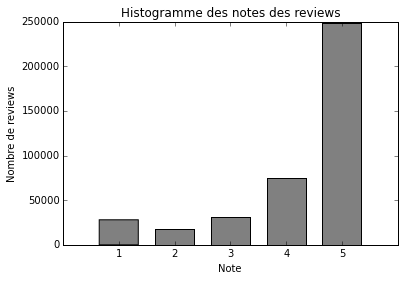

In [9]:
print(df_train["overall"].describe().round(2))
%matplotlib inline 
a=[int(i) for i in df_train["overall"]]
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes des reviews");
plt.xlabel("Note");
plt.ylabel("Nombre de reviews");

Regardons la distribution des notes moyennes par produit. On constate que la distribution est moins "skewed" que précedemment.

count    75036.00
mean         4.23
std          1.00
min          1.00
25%          4.00
50%          4.57
75%          5.00
max          5.00
Name: overall, dtype: float64


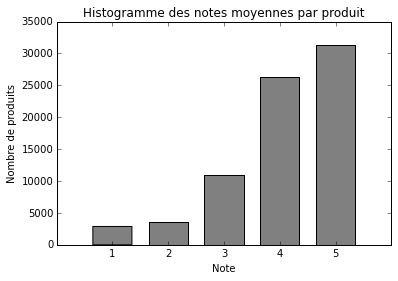

In [10]:
average_note_byproduct=df_train[["asin","overall"]].groupby("asin", as_index=False).mean()
print(average_note_byproduct["overall"].describe().round(2))
%matplotlib inline 
bins=range(1,7)
fig, ax = plt.subplots(1,1)
ax.hist(average_note_byproduct["overall"], bins=bins, align='left', color="grey", rwidth=0.7)
ax.set_xticks(bins[:-1])
plt.title("Histogramme des notes moyennes par produit");
plt.xlabel("Note");
plt.ylabel("Nombre de produits");

Regardons la distribution du nombre de reviews par utilisateur.

count    283374.00
mean          1.41
std           2.05
min           1.00
25%           1.00
50%           1.00
75%           1.00
max         389.00
dtype: float64


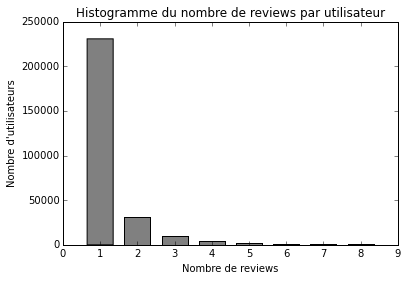

In [11]:
import collections
Nbreview_by_user=collections.Counter(df_train["reviewerID"])
print(pd.Series(Nbreview_by_user).describe().round(2))
bins=range(1,10,1)
a = np.clip(list(Nbreview_by_user.values()), 1, 10)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de reviews par utilisateur");
plt.xlabel("Nombre de reviews");
plt.ylabel("Nombre d'utilisateurs");

Définissons la fonction de comptage du nombre de mots d'une review et appliquons la à nos données

In [12]:
def countWords(review):
    return(len(review.split()))

In [13]:
df_train["countWordsReview"] = df_train["reviewText"].apply(countWords)
df_test["countWordsReview"] = df_test["reviewText"].apply(countWords)
df_train["countWordsSummary"] = df_train["summary"].apply(countWords)
df_test["countWordsSummary"] = df_test["summary"].apply(countWords)

Regardons la distribution du nombre de mots des reviews

In [14]:
print(df_train["countWordsReview"].describe().round(2))

count    400146.00
mean         87.80
std         118.56
min           0.00
25%          28.00
50%          49.00
75%          99.00
max        5291.00
Name: countWordsReview, dtype: float64


KeyError: 0

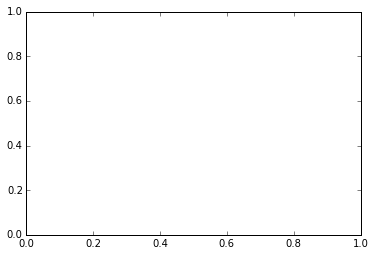

In [15]:
%matplotlib inline 
bins=range(0,430,30)
a = np.clip(df_train["countWordsReview"], 0, 400)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

Maintenant regardons plus spécifiquement entre 0 et 100 mots

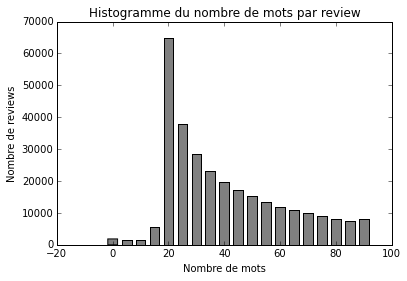

In [84]:
a = [s for s in df_train["countWordsReview"] if s < 101]
%matplotlib inline 
bins=range(0,100,5)
fig, ax = plt.subplots(1,1)
ax.hist(a, bins=bins, align='left', color="grey", rwidth=0.7)
plt.title("Histogramme du nombre de mots par review");
plt.xlabel("Nombre de mots");
plt.ylabel("Nombre de reviews");

## Préparation des données

On prépare les données de texte en utilisant la fonction `TfidfVectorizer` du package `sklearn`. Notons que nous utilisons les stopwords donnés par `nltk` pour réduire le nombre de mots.

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
tfidf_vect = TfidfVectorizer()
tfidf_vect_stopword = TfidfVectorizer(stop_words= stopwords.words('english'))

### 1. Texte complet de la review

#### a. Echantillon Train

In [203]:
corpus_train_reviewText=list(df_train["reviewText"])
X_train_tfidf_reviewText = tfidf_vect_stopword.fit_transform(corpus_train_reviewText)
X_train_tfidf_reviewText.shape

(400146, 219285)

#### b. Echantillon Test

In [204]:
corpus_test_reviewText=list(df_test["reviewText"])
X_test_tfidf_reviewText = tfidf_vect_stopword.transform(corpus_test_reviewText)
X_test_tfidf_reviewText.shape

(100037, 219285)

### 2. Texte du résumé de la review

#### a. Echantillon Train

In [205]:
corpus_train_summary=list(df_train["summary"])
X_train_tfidf_summary = tfidf_vect_stopword.fit_transform(corpus_train_summary)
X_train_tfidf_summary.shape

(400146, 42029)

#### b. Echantillon Test

In [206]:
corpus_test_summary=list(df_test["summary"])
X_test_tfidf_summary = tfidf_vect_stopword.transform(corpus_test_summary)
X_test_tfidf_summary.shape

(100037, 42029)

### 3. Features supplémentaires

Nous allons créer des variables pour le mois et le jour de la review, ce qui peut influencer la note.

In [207]:
from datetime import datetime
df_train["Weekday"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_test["Weekday"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%a')).astype('category')
df_train["Weekday"].head()

104407    Wed
441365    Wed
397753    Mon
459007    Thu
126387    Tue
Name: Weekday, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]

In [208]:
df_train["Month"] = df_train["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_test["Month"] = df_test["unixReviewTime"].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x),'%m')).astype('category')
df_train["Month"].head()

104407    10
441365    05
397753    04
459007    07
126387    11
Name: Month, dtype: category
Categories (12, object): [01, 02, 03, 04, ..., 09, 10, 11, 12]

In [209]:
from sklearn.feature_extraction import DictVectorizer
dic_vec = DictVectorizer()

#### a. Echantillon Train

In [210]:
from sklearn.preprocessing import normalize
X_train_countWords=normalize(df_train[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_train_countWords.shape)

(400146, 2)


In [211]:
dic_train_weekdays = pd.DataFrame(df_train["Weekday"]).to_dict('records')
X_train_weekdays = dic_vec.fit_transform(dic_train_weekdays)
X_train_weekdays.shape

(400146, 7)

In [212]:
dic_train_months = pd.DataFrame(df_train["Month"]).to_dict('records')
X_train_months = dic_vec.fit_transform(dic_train_months)
X_train_months.shape

(400146, 12)

#### b. Echantillon Test

In [213]:
from sklearn.preprocessing import normalize
X_test_countWords=normalize(df_test[["countWordsReview","countWordsSummary"]].astype(float),axis=0)
print(X_test_countWords.shape)

(100037, 2)


In [214]:
dic_test_weekdays = pd.DataFrame(df_test["Weekday"]).to_dict('records')
X_test_weekdays = dic_vec.fit_transform(dic_test_weekdays)
X_test_weekdays.shape

(100037, 7)

In [215]:
dic_test_months = pd.DataFrame(df_test["Month"]).to_dict('records')
X_test_months = dic_vec.fit_transform(dic_test_months)
X_test_months.shape

(100037, 12)

### 4. Combinaison de toutes les features

#### a. Echantillon Train

In [216]:
from scipy.sparse import hstack
X_train_alltext=hstack([X_train_tfidf_reviewText, X_train_tfidf_summary])
print(X_train_alltext.shape)

(400146, 261314)


In [217]:
X_train_textwordcount=hstack([X_train_alltext,X_train_countWords])
X_train_textwordcount.shape

(400146, 261316)

In [218]:
X_train_allfeatures = hstack([X_train_textwordcount, X_train_weekdays, X_train_months])
print(X_train_allfeatures.shape)

(400146, 261335)


In [219]:
X_train_supfeatures = hstack([X_train_countWords, X_train_weekdays, X_train_months])
print(X_train_supfeatures.shape)

(400146, 21)


#### b. Echantillon Test

In [220]:
X_test_alltext=hstack([X_test_tfidf_reviewText, X_test_tfidf_summary])
print(X_test_alltext.shape)

(100037, 261314)


In [221]:
X_test_textwordcount=hstack([X_test_alltext,X_test_countWords])
X_test_textwordcount.shape

(100037, 261316)

In [222]:
X_test_allfeatures = hstack([X_test_textwordcount, X_test_weekdays, X_test_months])
print(X_test_allfeatures.shape)

(100037, 261335)


In [223]:
X_test_supfeatures = hstack([X_test_countWords, X_test_weekdays, X_test_months])
print(X_test_supfeatures.shape)

(100037, 21)


## Machine Learning

En utilisant la librairie `sklearn`, nous allons appliquer les modèles suivants:
- Naive Bayes avec modèle multinomial, 
- Support Vector Machines avec Stochastic Gradient Descent et fonction de perte logistique, 
- k-Nearest Neighbors. 

Nous avons essayé des Random Forests mais les calculs n'ont jamais pu aboutir, compte tenu du grand nombre de dimensions. Nous avons choisi un modèle Multinomial pour le Naive Bayes car il est bien adapté aux données (matrice sparse de grande dimension). Un modèle Naive Bayes gaussian n'est pas compatible avec les matrices sparses, et un modèle Naive Bayes Bernoulli ne peut prendre que des variables booléennes en entrée. Quant au choix de la fonction de perte logistique pour le modèle Support Vector Machines, c'est la seule fonction qui permet de calculer des probabilités sur les valeurs prédites et donc de déterminer le critère AUC.

### 1. Texte complet de la review

In [224]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)

In [225]:
from sklearn.linear_model import SGDClassifier
SGDclass = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train.astype('category'))
predicted_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)

### 2. Texte du résumé de la review

In [226]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)

In [227]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train.astype('category'))
predicted_SVM_summary = clf2.predict(X_test_tfidf_summary)

### 3. Texte complet et résumé de la review

In [228]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_alltext, y_train.astype('category'))
predicted_NaiveBayes_alltext = clf.predict(X_test_alltext)

In [229]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_alltext, y_train.astype('category'))
predicted_SVM_alltext = clf2.predict(X_test_alltext)

### 4. Features supplémentaires

In [230]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_supfeatures, y_train.astype('category'))
predicted_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)

In [231]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_supfeatures, y_train.astype('category'))
predicted_SVM_supfeatures = clf2.predict(X_test_supfeatures)

### 5. Combinaison de toutes les features

In [232]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_allfeatures, y_train.astype('category'))
predicted_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)

In [233]:
from sklearn.linear_model import SGDClassifier
clf2 = SGDclass.fit(X_train_allfeatures, y_train.astype('category'))
predicted_SVM_allfeatures = clf2.predict(X_test_allfeatures)

# Evaluation de la performance

### 1. Pour le texte complet de la review

In [234]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_reviewText == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_reviewText == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 62.2%
L'accuracy du classifieur SVM est de 62.1%


In [235]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_reviewText))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_reviewText))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.88      0.01      0.02      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.00      0.00      0.00      7646
        4.0       0.41      0.00      0.00     18559
        5.0       0.62      1.00      0.77     62139

avg / total       0.52      0.62      0.48    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.00      0.00      0.00      7646
        4.0       0.00      0.00      0.00     18559
        5.0       0.62      1.00      0.77     62139

avg / total       0.39      0.62      0.48    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [236]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_reviewText))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_reviewText))

Matrice de confusion du classifieur Naive Bayes 
 [[   60     0     0     0  7060]
 [    5     0     0     1  4567]
 [    1     0     0     3  7642]
 [    0     0     0     9 18550]
 [    2     0     2     9 62126]]
Matrice de confusion du classifieur SVM 
 [[    0     0     0     0  7120]
 [    0     0     0     0  4573]
 [    0     0     0     0  7646]
 [    0     0     0     0 18559]
 [    0     0     0     0 62139]]


### 2. Pour le résumé de la review

In [237]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_summary == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_summary == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 66.4%
L'accuracy du classifieur SVM est de 62.4%


In [238]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_summary))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_summary))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.67      0.40      0.50      7120
        2.0       0.34      0.01      0.01      4573
        3.0       0.49      0.11      0.18      7646
        4.0       0.38      0.07      0.12     18559
        5.0       0.68      0.99      0.80     62139

avg / total       0.59      0.66      0.57    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       1.00      0.00      0.00      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.67      0.03      0.05      7646
        4.0       0.42      0.03      0.05     18559
        5.0       0.63      0.99      0.77     62139

avg / total       0.59      0.62      0.49    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [239]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_summary))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_summary))

Matrice de confusion du classifieur Naive Bayes 
 [[ 2867    25   180   311  3737]
 [  802    24   387   324  3036]
 [  331    15   851   943  5506]
 [  130     2   223  1344 16860]
 [  131     4    90   608 61306]]
Matrice de confusion du classifieur SVM 
 [[    2     0     3    57  7058]
 [    0     0    29    50  4494]
 [    0     0   207   148  7291]
 [    0     0    53   512 17994]
 [    0     0    17   450 61672]]


### 3. Texte complet et résumé de la review

In [240]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_alltext == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_alltext == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 64.8%
L'accuracy du classifieur SVM est de 62.8%


In [241]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_alltext))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_alltext))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.82      0.28      0.41      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.60      0.03      0.05      7646
        4.0       0.31      0.04      0.07     18559
        5.0       0.65      1.00      0.79     62139

avg / total       0.57      0.65      0.54    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.97      0.02      0.04      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.68      0.03      0.06      7646
        4.0       0.48      0.04      0.07     18559
        5.0       0.63      0.99      0.77     62139

avg / total       0.60      0.63      0.50    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [242]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_alltext))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_alltext))

Matrice de confusion du classifieur Naive Bayes 
 [[ 1975     0    16   227  4902]
 [  301     0    78   347  3847]
 [   95     0   200   892  6459]
 [   17     0    29   717 17796]
 [   20     1    10   158 61950]]
Matrice de confusion du classifieur SVM 
 [[  162     0     6    64  6888]
 [    4     0    35    69  4465]
 [    0     0   230   242  7174]
 [    0     0    51   698 17810]
 [    1     0    17   389 61732]]


### 4. Features supplémentaires

In [243]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_supfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_supfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 62.1%
L'accuracy du classifieur SVM est de 62.1%


In [244]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_supfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_supfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.00      0.00      0.00      7646
        4.0       0.00      0.00      0.00     18559
        5.0       0.62      1.00      0.77     62139

avg / total       0.39      0.62      0.48    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.00      0.00      0.00      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.00      0.00      0.00      7646
        4.0       0.00      0.00      0.00     18559
        5.0       0.62      1.00      0.77     62139

avg / total       0.39      0.62      0.48    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [245]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_supfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_supfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[    0     0     0     0  7120]
 [    0     0     0     0  4573]
 [    0     0     0     0  7646]
 [    0     0     0     0 18559]
 [    0     0     0     0 62139]]
Matrice de confusion du classifieur SVM 
 [[    0     0     0     0  7120]
 [    0     0     0     0  4573]
 [    0     0     0     0  7646]
 [    0     0     0     0 18559]
 [    0     0     0     0 62139]]


On constate qu'il s'agit d'un classifieur sans intérêt, car il ne prédit que des 5.

### 3. Pour la combinaison des features

In [246]:
print("L'accuracy du classifieur Naive Bayes est de "+str((np.mean(predicted_NaiveBayes_allfeatures == y_test)*100).round(1))+"%")
print("L'accuracy du classifieur SVM est de "+str((np.mean(predicted_SVM_allfeatures == y_test)*100).round(1))+"%")

L'accuracy du classifieur Naive Bayes est de 64.3%
L'accuracy du classifieur SVM est de 62.8%


In [247]:
print("Performance par classe du classifieur Naive Bayes \n",sklearn.metrics.classification_report(y_test, predicted_NaiveBayes_allfeatures))
print("Performance par classe du classifieur SVM \n",sklearn.metrics.classification_report(y_test, predicted_SVM_allfeatures))

Performance par classe du classifieur Naive Bayes 
              precision    recall  f1-score   support

        1.0       0.84      0.23      0.36      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.60      0.01      0.02      7646
        4.0       0.28      0.03      0.06     18559
        5.0       0.65      1.00      0.78     62139

avg / total       0.56      0.64      0.53    100037

Performance par classe du classifieur SVM 
              precision    recall  f1-score   support

        1.0       0.94      0.03      0.05      7120
        2.0       0.00      0.00      0.00      4573
        3.0       0.67      0.03      0.06      7646
        4.0       0.47      0.04      0.07     18559
        5.0       0.63      0.99      0.77     62139

avg / total       0.60      0.63      0.50    100037



/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [248]:
print("Matrice de confusion du classifieur Naive Bayes \n",sklearn.metrics.confusion_matrix(y_test, predicted_NaiveBayes_allfeatures))
print("Matrice de confusion du classifieur SVM \n",sklearn.metrics.confusion_matrix(y_test, predicted_SVM_allfeatures))

Matrice de confusion du classifieur Naive Bayes 
 [[ 1615     0     9   221  5275]
 [  227     0    42   329  3975]
 [   55     0    92   866  6633]
 [    9     0     6   615 17929]
 [    9     0     4   134 61992]]
Matrice de confusion du classifieur SVM 
 [[  188     0     6    66  6860]
 [    9     0    35    67  4462]
 [    0     0   233   252  7161]
 [    0     0    57   700 17802]
 [    2     0    16   398 61723]]


## Simplification du problème en classification binaire

En étudiant les matrices de confusion obtenues, on voit qu'il est difficile de prédire distinctement les notes entre 1 et 4. Nous allons donc nous ramener à un sous-problème de classification binaire, c'est-à-dire de prédire si la note sera de 5 ou non.

In [253]:
def bin_transformation(x):
    if x==5:
        return("1")
    else:
        return("0")

In [254]:
y_train_bin=y_train.apply(bin_transformation).astype("category")
y_test_bin=y_test.apply(bin_transformation).astype("category")

On ré-entraîne tous les classifieurs pour ce problème binaire:

In [255]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_NaiveBayes_reviewText = clf.predict(X_test_tfidf_reviewText)
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
predicted_bin_SVM_reviewText = clf2.predict(X_test_tfidf_reviewText)
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_NaiveBayes_summary = clf.predict(X_test_tfidf_summary)
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
predicted_bin_SVM_summary = clf2.predict(X_test_tfidf_summary)
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
predicted_bin_NaiveBayes_alltext = clf.predict(X_test_alltext)
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
predicted_bin_SVM_alltext = clf2.predict(X_test_alltext)
#Features supplémentaires
clf = MultinomialNB().fit(X_train_supfeatures, y_train_bin)
predicted_bin_NaiveBayes_supfeatures = clf.predict(X_test_supfeatures)
clf2 = SGDclass.fit(X_train_supfeatures, y_train_bin)
predicted_bin_SVM_supfeatures = clf2.predict(X_test_supfeatures)
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
predicted_bin_NaiveBayes_allfeatures = clf.predict(X_test_allfeatures)
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
predicted_bin_SVM_allfeatures = clf.predict(X_test_allfeatures)

Maintenant on peut réévaluer l'ensemble des classifieurs sur nos features. Notons qu'on calcule les indicateurs Precision, Recall et f1-score pour le label "5" uniquement étant donné que le problème est binaire.

In [256]:
index_clf=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
           "Alltext-NaiveBayes","Alltext-SVM","Supfeatures-NaiveBayes","Supfeatures-SVM",
          "Allfeatures-NaiveBayes","Allfeatures-SVM"]
predicted_clf=[predicted_bin_SVM_reviewText, predicted_bin_SVM_reviewText, 
              predicted_bin_NaiveBayes_summary, predicted_bin_SVM_summary,
             predicted_bin_NaiveBayes_alltext, predicted_bin_SVM_alltext,
             predicted_bin_NaiveBayes_supfeatures, predicted_bin_SVM_supfeatures,
             predicted_bin_NaiveBayes_allfeatures, predicted_bin_SVM_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall,f1-score
ReviewText-NaiveBayes,67.5%,65.9%,99.0%,79.1%
ReviewText-SVM,67.5%,65.9%,99.0%,79.1%
Summary-NaiveBayes,74.7%,73.8%,91.9%,81.9%
Summary-SVM,67.5%,66.3%,96.8%,78.7%
Alltext-NaiveBayes,78.7%,76.8%,94.2%,84.6%
Alltext-SVM,74.7%,72.3%,96.0%,82.5%
Supfeatures-NaiveBayes,62.1%,62.1%,100.0%,76.6%
Supfeatures-SVM,62.1%,62.1%,100.0%,76.6%
Allfeatures-NaiveBayes,78.6%,76.6%,94.5%,84.6%
Allfeatures-SVM,78.6%,76.6%,94.5%,84.6%


On voit que le classifieur le plus performant est le **Naive Bayes sur tout le texte**, sans les features supplémentaires. L'ajout des features supplémentaires n'augmente pas particulièrement la performance, sauf pour le modèle SVM, qui reste cependant en dessous du NaiveBayes. De manière générale, la performance des classifieurs SVM est inférieure ou égale à celle des classifieurs Naive Bayes.

Enfin, pour évaluer la performance, nous allons tracer la courbe de ROC et évaluer le critère AUC. Pour faciliter la lisibilité du graphique, on élimine le classifieur uniquement sur les variables supplémentaires, car celui-ci ne prédit que des 5.

In [257]:
#Texte complet de la review
clf = MultinomialNB().fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_NaiveBayes_reviewText = clf.predict_proba(X_test_tfidf_reviewText)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_reviewText, y_train_bin)
probas_bin_SVM_reviewText = clf2.predict_proba(X_test_tfidf_reviewText)[:,1]
#Texte du résumé de la review
clf = MultinomialNB().fit(X_train_tfidf_summary, y_train_bin)
probas_bin_NaiveBayes_summary = clf.predict_proba(X_test_tfidf_summary)[:,1]
clf2 = SGDclass.fit(X_train_tfidf_summary, y_train_bin)
probas_bin_SVM_summary = clf2.predict_proba(X_test_tfidf_summary)[:,1]
#Texte complet et résumé de la review
clf = MultinomialNB().fit(X_train_alltext, y_train_bin)
probas_bin_NaiveBayes_alltext = clf.predict_proba(X_test_alltext)[:,1]
clf2 = SGDclass.fit(X_train_alltext, y_train_bin)
probas_bin_SVM_alltext = clf2.predict_proba(X_test_alltext)[:,1]
#Combinaison de toutes les features
clf = MultinomialNB().fit(X_train_allfeatures, y_train_bin)
probas_bin_NaiveBayes_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]
clf2 = SGDclass.fit(X_train_allfeatures, y_train_bin)
probas_bin_SVM_allfeatures = clf.predict_proba(X_test_allfeatures)[:,1]

/Users/thibaut/anaconda/lib/python3.4/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


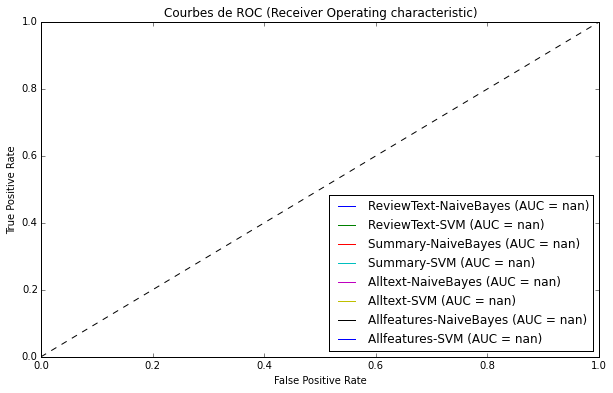

In [258]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)
from sklearn.metrics import roc_curve, auc
probas = [probas_bin_NaiveBayes_reviewText,probas_bin_SVM_reviewText,
         probas_bin_NaiveBayes_summary, probas_bin_SVM_summary,
         probas_bin_NaiveBayes_alltext, probas_bin_SVM_alltext,
         probas_bin_NaiveBayes_allfeatures, probas_bin_SVM_allfeatures]
labels=["ReviewText-NaiveBayes","ReviewText-SVM","Summary-NaiveBayes","Summary-SVM",
        "Alltext-NaiveBayes","Alltext-SVM","Allfeatures-NaiveBayes","Allfeatures-SVM"]
fpr= [None] * len(probas)
tpr=[None] * len(probas)
thresholds=[None] * len(probas)
roc_auc=[None] * len(probas)
for i in range(len(probas)):    
    fpr[i], tpr[i], thresholds[i] = sklearn.metrics.roc_curve(y_test_bin.ravel(), probas[i], pos_label="5")
    roc_auc[i]=auc(fpr[i],tpr[i])
    plt.plot(fpr[i], tpr[i], label=labels[i]+" (AUC = %0.2f)" % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes de ROC (Receiver Operating characteristic)')
plt.legend(loc="lower right")

On voit que l'apport des features supplémentaires n'importe qu'un petit gain d'AUC au classifieur SVM. Les modèles Naive Bayes sont toujours bien supérieurs en termes d'AUC aux modèles SVM.

## Optimisation des hyper-paramètres pour la classification binaire

Nous allons nous concentrer ici sur l'optimisation des hyperparamètres de chacun des classifieurs sur l'intégralité des features.

### 1. Optimisation du classifieur Naive Bayes

In [140]:
from sklearn import grid_search
parameters_NB = {'alpha':list(np.linspace(0.001,10,50))}
clf1=grid_search.GridSearchCV(MultinomialNB(), parameters_NB)
clf1.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.20506122448979594, 0.40912244897959188, 0.61318367346938785, 0.81724489795918376, 1.0213061224489797, 1.2253673469387756, 1.4294285714285715, 1.6334897959183674, 1.8375510204081633, 2.0416122448979594, 2.2456734693877554, 2.4497346938775513, 2.6537959183673472, 2.85785...6938775510213, 9.1837551020408164, 9.3878163265306132, 9.5918775510204082, 9.795938775510205, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [159]:
best_parameters, score, _ = max(clf1.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_NB.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 0.40912244897959188


In [160]:
score

0.78690777866078876

### 2. Optimisation du classifieur SVM

In [169]:
parameters_SVM = {'alpha':list(np.linspace(0.000001,0.001,50)),
                  'loss':["modified_huber","log"],
                  'penalty': ["l2", "l1","elasticnet"],
                 }
clf2=grid_search.GridSearchCV(SGDClassifier(), parameters_SVM)
clf2.fit(X_train_allfeatures, y_train_bin)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['modified_huber', 'log'], 'alpha': [9.9999999999999995e-07, 2.1387755102040818e-05, 4.1775510204081632e-05, 6.2163265306122456e-05, 8.2551020408163267e-05, 0.00010293877551020408, 0.00012332653061224492, 0.00014371428571428573, 0.0001641020...00091844897959183678, 0.00093883673469387764, 0.0009592244897959184, 0.00097961224489795926, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [170]:
best_parameters, score, _ = max(clf2.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters_SVM.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

alpha: 0.00016410204081632654
loss: 'modified_huber'
penalty: 'l2'


In [287]:
predicted_bin_SVM_optim_allfeatures = clf2.predict(X_test_allfeatures)

### Comparaison de performance entre classifieurs optimisés et non optimisés

In [291]:
index_clf=["NaiveBayes-Basic","NaiveBayes-Optimized","SVM-Basic","SVM-Optimized"]
predicted_clf=[predicted_bin_NaiveBayes_allfeatures, predicted_bin_NaiveBayes_optim_allfeatures,
               predicted_bin_SVM_allfeatures, predicted_bin_SVM_optim_allfeatures]
def percent_round1(x):
    return(str((x*100).round(1))+"%")
Accuracy_clf=[percent_round1(np.mean(x==y_test_bin)) for x in predicted_clf]
Report_clf=[sklearn.metrics.precision_recall_fscore_support(y_test_bin, x) for x in predicted_clf]
Precision_clf=[percent_round1(x[0][1]) for x in Report_clf]
Recall_clf=[percent_round1(x[1][1]) for x in Report_clf]
f1score_clf=[percent_round1(x[2][1]) for x in Report_clf]

dic_clf = {'Accuracy' : pd.Series(Accuracy_clf, index=index_clf),
     'Precision' : pd.Series(Precision_clf, index=index_clf),
     'Recall' : pd.Series(Recall_clf, index=index_clf),
     'f1-score': pd.Series(f1score_clf, index=index_clf),
    }
df_clf=pd.DataFrame(dic_clf)
df_clf

,Accuracy,Precision,Recall,f1-score
NaiveBayes-Basic,78.2%,76.1%,94.3%,84.2%
NaiveBayes-Optimized,78.7%,77.9%,91.5%,84.2%
SVM-Basic,78.2%,76.1%,94.3%,84.2%
SVM-Optimized,81.3%,81.2%,90.8%,85.7%


On voit que l'optimisation est sensible pour le classifieur SVM, qui dépasse maintenant le classifieur Naive Bayes, sauf en termes de recall. Cependant, le temps de calcul a été beaucoup plus long pour SVM que pour Naive Bayes.

## Analyse de la performance en fonction du nombre de mots

In [259]:
def createBins(x):
    if x["countWordsReview"] < 17:
        return(17)
    elif x["countWordsReview"] < 30:
        return(30)
    elif x["countWordsReview"] < 60:
        return(60)
    elif x["countWordsReview"] < 100:
        return(100)
    elif x["countWordsReview"] < 200:
        return(200)
    else:
        return(300)

In [145]:
dfy = pd.DataFrame(y_test)

In [146]:
dfy["predicted"] = predicted_bin_SVM_allfeatures

In [147]:
dfy["reviewText"] = df_test["reviewText"]

In [148]:
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)

In [182]:
type(predicted_bin_SVM_allfeatures)

numpy.ndarray

In [184]:
predicted_bin_SVM_allfeatures

array(['5', '5', '5', ..., '5', '5', '5'], 
      dtype='<U3')

In [183]:
y_test

117787    1
16972     1
341789    1
492202    1
425536    1
386048    0
135278    1
439217    0
289326    0
169907    1
402299    1
330724    1
97980     0
33289     1
247093    1
387134    0
162474    0
416906    0
18176     1
1859      1
80578     1
367794    0
268270    1
61690     0
160958    0
402680    0
411954    0
490793    1
210193    1
379576    1
         ..
385013    1
320725    0
24736     0
218380    1
452166    0
189652    1
49712     1
80159     1
229406    1
18657     0
244182    0
446180    1
201116    0
422103    1
29724     0
234996    0
430184    1
126755    0
252019    1
106482    1
242889    0
7185      1
389570    1
173152    1
68720     1
309437    1
72255     1
54775     0
403348    1
498027    1
Name: overall, dtype: int64

In [144]:
dfy = pd.DataFrame(y_test)
dfy["predicted"] = predicted_bin_SVM_allfeatures
dfy["reviewText"] = df_test["reviewText"]
dfy["countWordsReview"] = dfy["reviewText"].apply(countWords)
dfy["qualite"] = abs(predicted_bin_SVM_allfeatures - y_test)
dfy["bin"] = dfy.apply(createBins, axis = 1)
dfy.head()

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [ ]:
np.mean(dfy[dfy.bin==30]["qualite"])

In [ ]:
sum(abs(predicted_reviewText - y_test))

## Bits of useless code (so far)

In [ ]:
#an example with another function TfidfVectorizer using frequency instead of count
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = ["This is very strange",
          "This is very nice"]
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
print(dict(zip(vectorizer.get_feature_names(), idf)))

In [ ]:
# A possible approach that would require to construct pipelines
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import HashingVectorizer
hash_vect = HashingVectorizer()

In [ ]:
for i in range(0,5) :
        print(str(corpus_test_reviewText[i]) +"\n"+ "------ We predict "+ str(predicted_reviewText[i])+"\n")

Then: draw multi class ROC Curve using this example: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# Todo

- Analyse de la performance en fonction du nombre de mots
- Ajout d'un classifieur kNN
- Analyse des features les plus importantes dans chaque modèle